# 第二組作業：民眾對五倍卷發行的觀感進行情緒分析
組員: 曾天鈞、鍾君右、周駿嚴、龔紫雲、周紘樟、蕭清耀  
Date created: 2021/10/26  
Last modified: 2021/11/01


In [8]:
%pwd

'C:\\Users\\Cloudie\\Desktop\\社群媒體分析'

In [9]:
import pandas
import jieba
import jieba.analyse
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import datetime

In [10]:
plt.rcParams['font.sans-serif']=['SimHei']

## 基本資料介紹  
資料來源：文字平台收集 PTT Gossip/MobilePay版 2021/09/20－2021/10/20 所有文章  
資料集： ./五倍券Gossip+MobilePay_articleMetaData.csv  
關鍵字：振興券、五倍券、三倍券、紙本、數位、綁定、紙本綁定、數位綁定、信用卡、優惠、折扣、回饋、加碼  
資料時間：2021-09-20－2021-10-20  

主要分析ptt上網友的相關討論，而本組主要針對以下方向分析：　　
1. 民眾對於五倍券的討論於發行前後的情緒反應？　　
2. 正面和負面的討論內容各是甚麼，有沒有時間點上的差異？

In [11]:
#匯入資料
MetaData = pd.read_csv('./五倍券Gossip+MobilePay_articleMetaData.csv', encoding='UTF-8')
Reviews = pd.read_csv('./五倍券Gossip+MobilePay_articleReviews.csv', encoding='UTF-8')

In [12]:
print(f"共有 {MetaData.shape[0]} 篇文章") #(row,column)
MetaData.head(3)

共有 1750 篇文章


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,5,2,0,綁數位就是綁手綁腳\n\n要搞懂超多遊戲規則\n\n還是乖乖領紙本就好\n\n很多八卦鄉民應...
1,[問卦]五倍券綁信用卡，刷卡內容有差嗎??,2021/09/21,16:05:00,https://www.ptt.cc/bbs/Gossiping/M.1632240302....,devidevi,Gossiping,9,4,0,五倍券可以綁信用卡\n\n那信用卡刷卡的時候\n會審核刷卡內容\n符合補助的才能折抵五倍券，...
2,[問卦]早上9點時5倍券官網會發生什麼事,2021/09/21,16:06:15,https://www.ptt.cc/bbs/Gossiping/M.1632240378....,poeta,Gossiping,15,2,4,好緊張喔\n\n早上九點就是五倍券綁定的時間了\n\n要搶名額有限的早鳥優惠 一定要趁早綁對...


In [13]:
print(f"共有 {Reviews.shape[0]} 個留言")
Reviews.head(3)

共有 86779 個留言


,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,pooznn,→,2021-09-22 00:04:00,:悠遊卡進不去...
1,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,cena0605,推,2021-09-22 00:04:00,:要單純綁數位不是更快根本不缺那什麼福
2,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,cena0605,→,2021-09-22 00:04:00,:利


In [14]:
# 再使用關鍵字篩選一次文章
keywords = ['振興券','五倍券','三倍券','紙本','數位','綁定','紙本綁定','數位綁定','信用卡','優惠','折扣','回饋','加碼']
toMatch = '|'.join(keywords)

In [15]:
MetaData = MetaData.loc[MetaData['sentence'].str.contains(toMatch) | MetaData['artTitle'].str.contains(toMatch), :]
MetaData.reset_index(inplace=True, drop=True) #重設index
print(MetaData.shape)

(1649, 10)


In [16]:
# 挑選文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent"]], how = "left", on = 'artUrl')

In [17]:
print(Reviews.shape)
Reviews.head(3)

(83954, 10)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
0,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,5,2,0,:悠遊卡進不去...
1,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,5,2,0,:要單純綁數位不是更快根本不缺那什麼福
2,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,5,2,0,:利


In [18]:
# 移除cmtContent為na值的資料
Reviews.dropna(subset = ["cmtContent"], inplace=True)

In [19]:
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))

In [20]:
MetaData.head(3)
#MetaData['sentence']

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,5,2,0,綁數位就是綁手綁腳要搞懂超多遊戲規則還是乖乖領紙本就好很多八卦鄉民應該也是都想領紙本吧越單純...
1,[問卦]五倍券綁信用卡，刷卡內容有差嗎??,2021/09/21,16:05:00,https://www.ptt.cc/bbs/Gossiping/M.1632240302....,devidevi,Gossiping,9,4,0,五倍券可以綁信用卡那信用卡刷卡的時候會審核刷卡內容符合補助的才能折抵五倍券還是不分好比刷手遊...
2,[問卦]早上9點時5倍券官網會發生什麼事,2021/09/21,16:06:15,https://www.ptt.cc/bbs/Gossiping/M.1632240378....,poeta,Gossiping,15,2,4,好緊張喔早上九點就是五倍券綁定的時間了要搶名額有限的早鳥優惠一定要趁早綁對吧到時候官網發生什...


In [21]:
Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))
Reviews.head(3)
#Reviews['cmtContent']

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
0,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,5,2,0,悠遊卡進不去
1,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,5,2,0,要單純綁數位不是更快根本不缺那什麼福
2,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,5,2,0,利


## 文章斷詞  
我們使用jieba套件對於中文文集進行斷詞並移除停用字  
#### 在第一次分析之後，我們將停用字的部分新增疫苗、乞丐、高端、中國，因本次不探討疫苗施打與五倍券發行相關的評論。

In [22]:
#設定繁體中文詞庫
jieba.set_dictionary('./week4_sentiment_analysis1/dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/user_dict.txt')
#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from C:\Users\Cloudie\Desktop\社群媒體分析\week4_sentiment_analysis1\dict\dict.txt.big ...
Loading model from cache C:\Users\Cloudie\AppData\Local\Temp\jieba.ua57e8d3edbc72fa5df6d4d699f704206.cache
Loading model cost 3.093 seconds.
Prefix dict has been built successfully.


In [23]:
def getToken(row):
    
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [24]:
MetaData['word'] = MetaData.sentence.apply(getToken)

In [25]:
# 將word欄位展開
MetaData_token = MetaData.explode('word') 

In [26]:
MetaData_token.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,5,2,0,綁數位就是綁手綁腳要搞懂超多遊戲規則還是乖乖領紙本就好很多八卦鄉民應該也是都想領紙本吧越單純...,數位
0,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,5,2,0,綁數位就是綁手綁腳要搞懂超多遊戲規則還是乖乖領紙本就好很多八卦鄉民應該也是都想領紙本吧越單純...,綁手
0,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,5,2,0,綁數位就是綁手綁腳要搞懂超多遊戲規則還是乖乖領紙本就好很多八卦鄉民應該也是都想領紙本吧越單純...,綁腳


In [27]:
Reviews['word'] = Reviews.cmtContent.apply(getToken)

In [28]:
# 將word欄位展開
Reviews_token = Reviews.explode('word') 

In [29]:
Reviews_token.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent,word
0,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,5,2,0,悠遊卡進不去,悠遊
0,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,5,2,0,悠遊卡進不去,進不去
1,Re:[問卦]5倍券官網一堆(規劃中)_,2021/09/21,16:03:31,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,thouloveme,Gossiping,5,2,0,要單純綁數位不是更快根本不缺那什麼福,數位


In [30]:
# 合併斷詞後的本文與留言
data = pd.concat([MetaData_token.loc[:,["artDate","artUrl","word"]],Reviews_token.loc[:,["artDate","artUrl","word"]]],axis=0)
data.head()

,artDate,artUrl,word
0,2021/09/21,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,數位
0,2021/09/21,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,綁手
0,2021/09/21,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,綁腳
0,2021/09/21,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,搞懂
0,2021/09/21,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,超多


In [31]:
#轉換日期格式
data['artDate'] = pd.to_datetime(data['artDate'], format="%Y/%m/%d")

In [32]:
#計算每天不同字的詞頻
word_count = data.groupby(['artDate','word'],as_index=False).size()
word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count = word_count[word_count['size']>3]  #過濾出現太少次的字
word_count.head(30)

,artDate,word,size
11562,2021-09-22,綁定,638
3931,2021-09-22,五倍券,474
70191,2021-10-08,支付,469
8888,2021-09-22,政府,461
5692,2021-09-22,台灣,413
81327,2021-10-09,質量,389
11610,2021-09-22,綠班,371
11459,2021-09-22,紙本,359
8959,2021-09-22,數位,350
105325,2021-10-13,綠班,328


# lexicon-base 情緒分析  
使用LIWC字典  
經由資料搜尋與鄉民百科，天才於五倍券討論當中含有諷刺的意思，而塔綠班(綠班)含有暗諷政策實施者之意  
因此我們新增塔綠班、綠班、當機、垃圾到 negative 字典;而將天才由 positive 移動至 negative 字典。


In [33]:
filepath = ['negative','positive']
d_liwc = []
for file in filepath:
    filename = f"./week4_sentiment_analysis1/dict/liwc/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split(","),file])

In [34]:
df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_liwc

,word,sentiments
0,天才,negative
1,塔綠班,negative
2,綠班,negative
3,當機,negative
4,乞丐,negative
...,...,...
1711,魅力,positive
1712,鮮明,positive
1713,鮮美,positive
1714,鼓勵,positive


## 情緒字典與斷詞結果進行合併  
將情緒字典與斷詞結果進行合併。  
觀察每天的ptt文章數量，可以發現在09/21當天有最高的討論聲量，而在之後有逐漸下降的趨勢，直到10/08，討論聲量有明顯的回升。

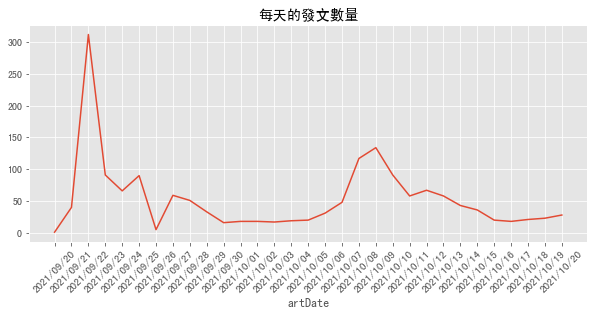

In [35]:
data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count'])

plt.figure(figsize=(10,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(data_datecount.index,data_datecount['count'].tolist())

## 正負向情緒分數聲量折線圖圖  
分別畫出五倍券討論文集中，正向（positive）與負向（negative）情緒的折線圖

In [36]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['artDate','sentiments'],as_index=False).size()
sentiment_count.head()

,artDate,sentiments,size
0,2021-09-20,negative,1
1,2021-09-20,positive,3
2,2021-09-21,negative,334
3,2021-09-21,positive,288
4,2021-09-22,negative,2883


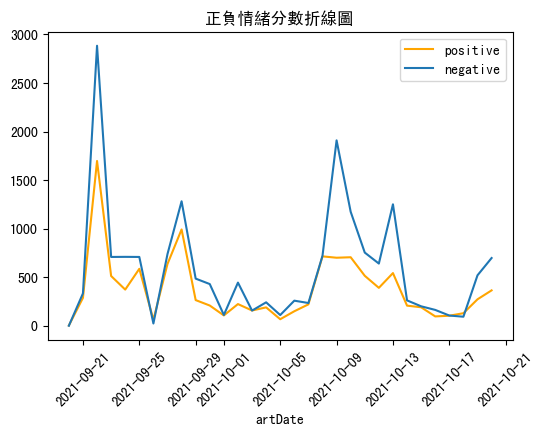

In [38]:
p = sentiment_count[sentiment_count['sentiments']=='positive']
n = sentiment_count[sentiment_count['sentiments']=='negative']

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒分數折線圖')
plt.plot(p['artDate'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
plt.xlabel('artDate')
plt.show()

圖表為每天的情緒總分數，可以看到大約在09/21、10/09、10/13這三天，負向情緒顯著高於正向情緒  
而以整體來看，民眾在五倍券發行之後，其負向情緒皆高於正向情緒。

## 正負向情緒分數比例折線圖圖

In [39]:
sentiment_count_r = sentiment_count.assign(ratio = sentiment_count.groupby(['artDate'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

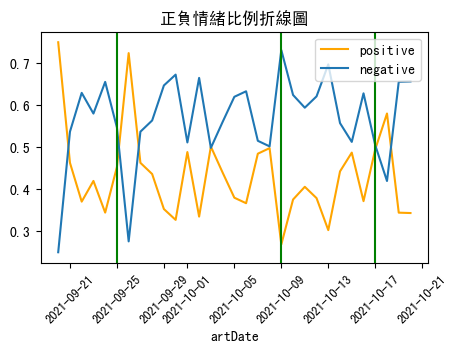

In [40]:
sentiment_count_r = sentiment_count_r[sentiment_count_r['artDate'] > '2021/09/01']
p = sentiment_count_r[sentiment_count_r['sentiments']=='positive']
n = sentiment_count_r[sentiment_count_r['sentiments']=='negative']

plt.figure(figsize=(5,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒比例折線圖')
plt.plot(p['artDate'].tolist(), p['ratio'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['ratio'], label='negative')
plt.xticks(rotation= 45, fontsize=9)
plt.legend() #顯示圖例
plt.axvline(x=datetime.strptime('2021-09-25', "%Y-%m-%d"), color="green", ls="-")
plt.axvline(x=datetime.strptime('2021-10-09', "%Y-%m-%d"), color="green", ls="-")
plt.axvline(x=datetime.strptime('2021-10-17', "%Y-%m-%d"), color="green", ls="-")
plt.xlabel('artDate')
plt.show()

透過上圖可以發現在09/25有一次情緒由負轉正的轉折，其中10/09為負向情緒的最高峰，而在10/17當天又有一次情緒由負轉正的轉折。

In [41]:
def Wc_dict(df, Date, countB, countS):
    wc_df = (df.query('artDate == @Date') # 篩選日期
             .query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict
    

## 文字雲  
針對不同日期畫出該天的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

### 2021-09-21 文字雲
0921為發行五倍券的前一天，此時文字雲出現較多中性詞彙，如「通路」、「回饋」、「銀行」、「店家」、「數位綁定」等  
網友對五倍券發行前做足功課，好奇哪個管道或方法能以最大效益使用五倍券，成為最大回饋贏家。

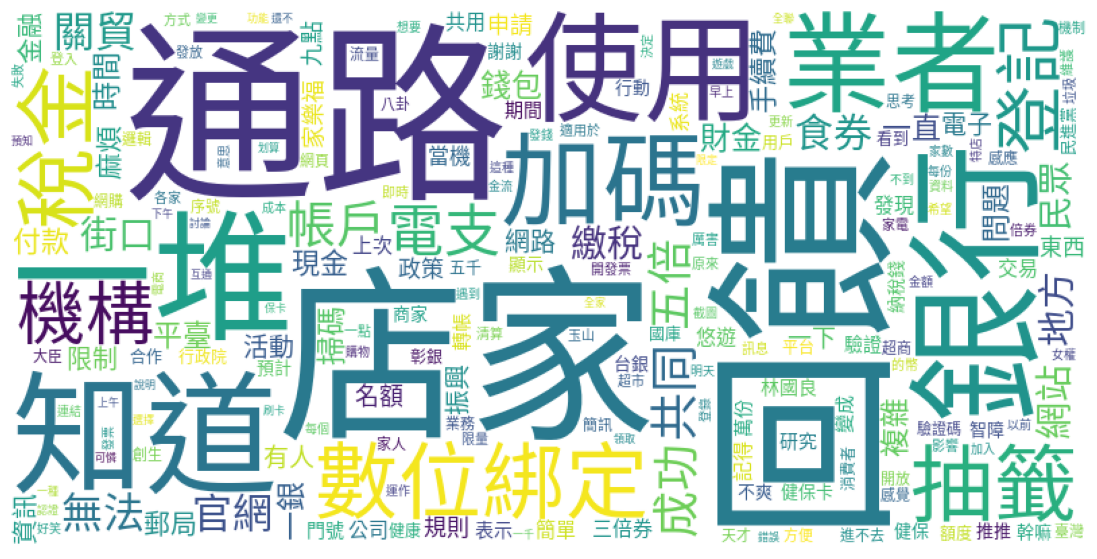

In [43]:
dict_0921 = Wc_dict(word_count,"2021-09-21",50,1)

font = './week4_sentiment_analysis1/SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_0921)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2021-10-09 文字雲  
10/09為負向情緒的最高峰，文字雲中出現較多的負面詞彙，如「綠班」、「天才」、「問題」，網友對五倍券充滿諷刺意涵，表達對這次五倍券發行的不滿。

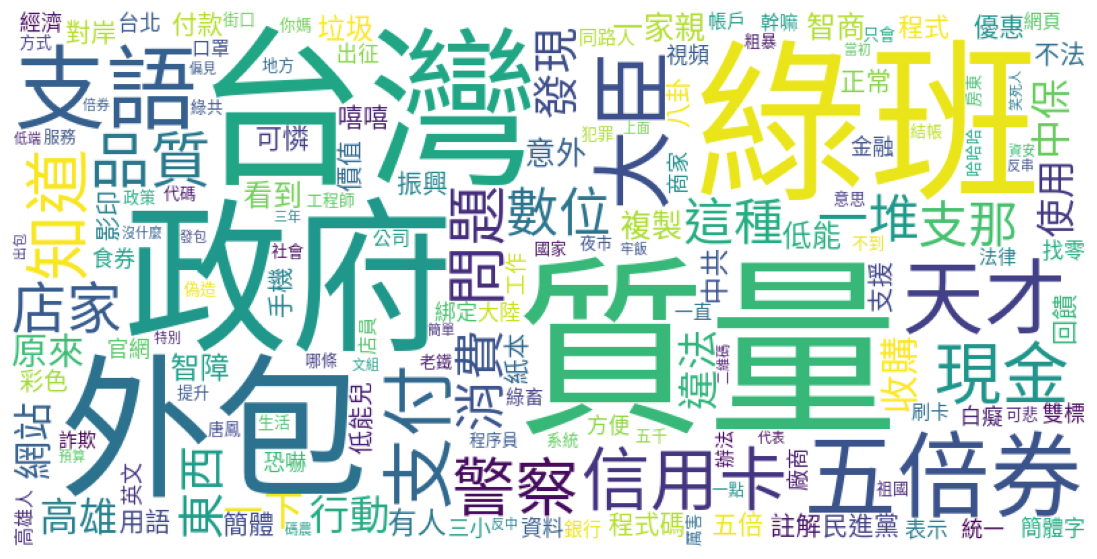

In [44]:
dict_1009 = Wc_dict(word_count,"2021-10-09",450,20)

font = './week4_sentiment_analysis1/SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1009)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

## 情緒代表字  
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字。

In [45]:
sentiment_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))
sentiment_sum = sentiment_sum.sort_values(by=['size'], ascending=False)  #排序
sentiment_sum.head()

,word,sentiments,size
230,綠班,negative,2577
71,垃圾,negative,1988
60,問題,negative,1352
32,優惠,positive,1211
79,天才,negative,1199


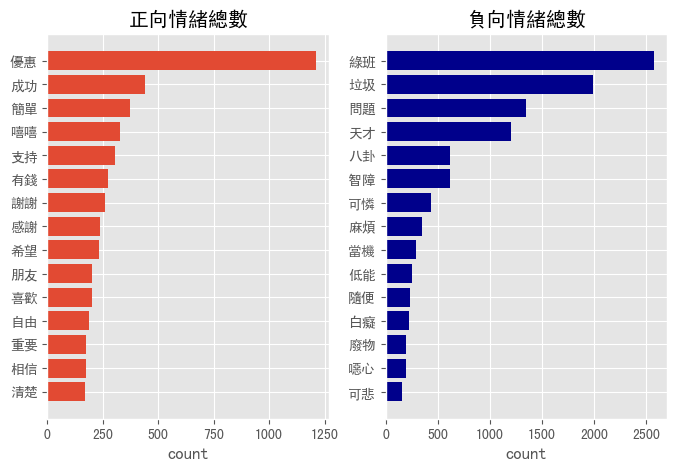

In [46]:
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

最後正面負面詞的總數比對，我們可以看到正面有"笑死"、"優惠"、"成功"、"簡單"，負面有"綠班"、"垃圾"、"問題"、"天才"、"八卦"  
負面排名第一的詞彙以壓倒性兩倍數量勝過正面排名第一的詞彙  
由此可見即使民眾對於五倍券保有正面的態度但是負面評價依舊占大多數。

## 歸類正負面文章
之前的情緒分析大部分是全部的詞彙加總，接下來將正負面情緒的文章分開，看看能不能發現一些新的東西。
接下來歸類文章，將每一篇文章正負面情緒的分數算出來，然後大概分類文章屬於正面還是負面。

In [47]:
article_type = (data.merge(df_liwc, on='word')
                .groupby(['artUrl', 'sentiments'], as_index=False)
                .size()
                .pivot_table(index='artUrl', columns='sentiments', values='size', fill_value=0)
                .reset_index(['artUrl'])
               )
article_type.head()

sentiments,artUrl,negative,positive
0,https://www.ptt.cc/bbs/Gossiping/M.1632240213....,1,0
1,https://www.ptt.cc/bbs/Gossiping/M.1632240378....,6,6
2,https://www.ptt.cc/bbs/Gossiping/M.1632240539....,1,8
3,https://www.ptt.cc/bbs/Gossiping/M.1632240735....,2,10
4,https://www.ptt.cc/bbs/Gossiping/M.1632240799....,10,6


In [48]:
article_type['type'] = article_type.apply(lambda x: 'positive' if x['positive'] > x['negative'] else 'negative',axis=1)
article_type.groupby('type', as_index=False).size()

,type,size
0,negative,959
1,positive,626


## 正負情緒文章數量統計圖

In [49]:
article_type_date = article_type.merge(MetaData.loc[:,["artUrl", "artDate"]], how = 'left', on = 'artUrl')
article_type_date = article_type_date.groupby(['artDate','type'], as_index=False).size()
#article_type_date

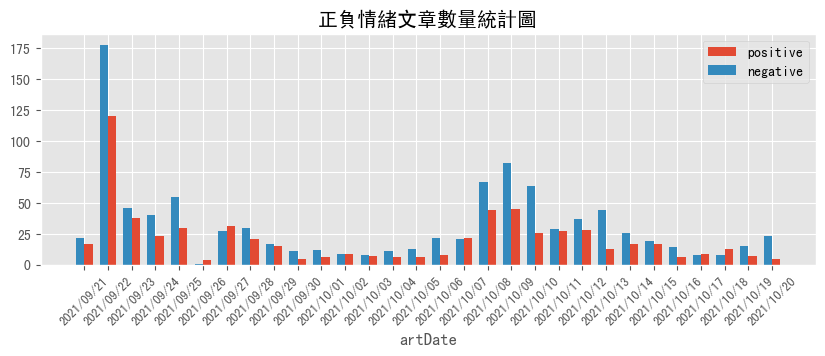

In [53]:
ap = article_type_date[(article_type_date["type"]=="positive")&(article_type_date["artDate"]>="2021/09/21")&(article_type_date["artDate"]<="2021/3/25")]
an = article_type_date[(article_type_date["type"]=="negative")&(article_type_date["artDate"]>="2021/09/21")&(article_type_date["artDate"]<="2021/3/25")]

plt.figure(figsize=(10,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.xlabel('artDate')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()

## 情緒關鍵字
把正面和負面的文章挑出來，並和斷詞結果合併

In [55]:
positive_article = article_type[article_type["type"]=="positive"].merge(data, how = 'left', on = 'artUrl')
negative_article = article_type[article_type["type"]=="negative"].merge(data, how = 'left', on = 'artUrl')

## 情緒關鍵字:負面情緒文章

In [56]:
negative_article = (negative_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

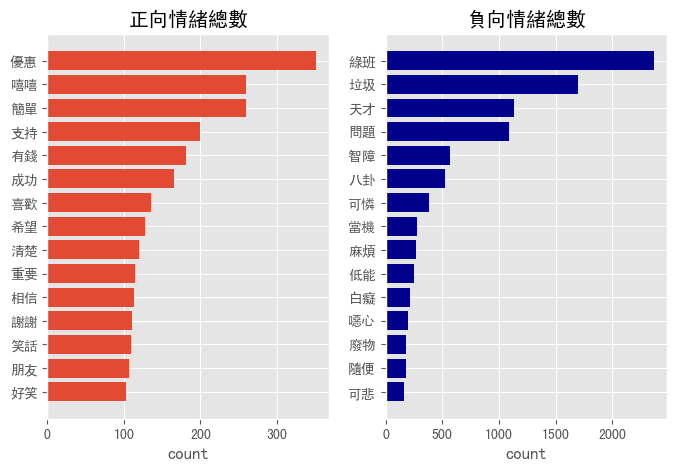

In [57]:
p_sum = negative_article[negative_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = negative_article[negative_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

## 情緒關鍵字:正面情緒文章

In [58]:
positive_article = (positive_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

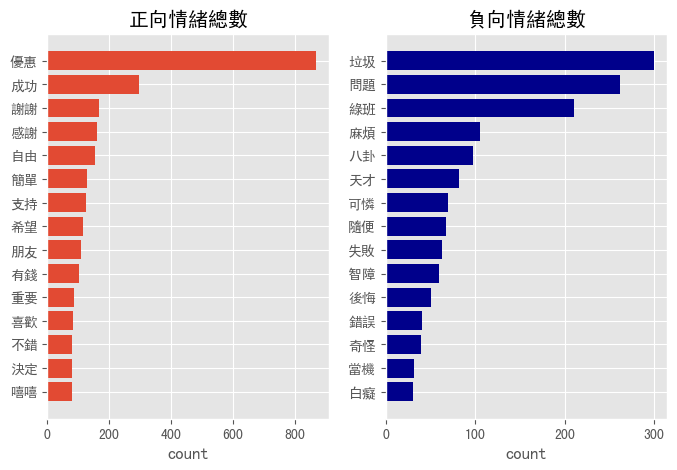

In [59]:
p_sum = positive_article[positive_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = positive_article[positive_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

從正負面情緒圖觀察發現，正面和負面的關鍵字沒有甚麼顯著的差異，負面情緒較高的文章比較常出現「垃圾」、「問題」、「綠班」、「天才」等討論五倍券政策執行者的字詞；正面情緒較高的文章出現較多的「成功」、「優惠」等字詞，著重在討論五倍券的優惠與使用回饋本身。